In [25]:
from IPython.display import clear_output 
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch
from torchvision.utils import make_grid
from torchvision.io import read_image
# from torchvision import models, transforms
# import sys
# import os
from PIL import Image
import torch
# import torch.functional as F
import numpy as np
clear_output()
# import glob
from utils import *
from datetime import date
from torch.optim import lr_scheduler
import torchvision
from constants import mean, std
from PapilledemaLoader import PapilledemaDataset, PapilSeverityDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score

In [26]:
data_dir = '/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity'
image_datasets = {x: PapilledemaDataset(data_dir=data_dir, phase=x) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

cuda:0 ['0', '1', '2', '3', '4', '5']


In [29]:
# # pretrain_mode = 'ConPro' #'


# # Load from ConPrO weights
# bestsmodel = SeverityModel().to(device)
# state_dict = torch.load('./pretrained/best-smodel50-wofreeze-2024-03-10.pt')
# bestsmodel.load_state_dict(state_dict)
# bestsmodel.bestsimese50simclr.cnn1.fc = torch.nn.Sequential(*(list(bestsmodel.bestsimese50simclr.cnn1.fc)+list(bestsmodel.bestsimese50simclr.cnn1.fc2)))
# torch.save(bestsmodel.bestsimese50simclr.cnn1.state_dict(), f'./pretrained/pretrained-resnet50-ConPro.pt')
# # Load from SupCon-2 weights
# smodel = SeverityModel(path2pretrained='./pretrained/best-contrastive50-2024-03-10.pt').to(device)
# torch.save(smodel.bestsimese50simclr.cnn1.state_dict(), f'./pretrained/pretrained-resnet50-SupCon.pt')
# # Load from SupCon-5 weights
smodel5 = SeverityModel(path2pretrained='./pretrained/best-multiclass-contrastive50-2024-03-18-latest.pt').to(device)
torch.save(smodel5.bestsimese50simclr.cnn1.state_dict(), f'./pretrained/pretrained-resnet50-SupCon5.pt')
# # Load from ImagesNet weights
# # Load from Simclr weights
# simclrweight = get_feature_extractor(feature_extractor='resnet50', cotrain=False, simclr='/mnt/c/Users/PCM/Dropbox/pretrained/SimCLR/checkpoint_0050.pth.tar')
# torch.save(simclrweight.state_dict(), f'./pretrained/pretrained-resnet50-SimCLR.pt')

load simclr resnet


## Re-Run from here to keep same dataset randomness

In [9]:
pretrain_mode = 'SimCLR'

clf_model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
clf_model.load_state_dict(torch.load(f'./pretrained/pretrained-resnet50-{pretrain_mode}.pt'), strict=False)
clf_model.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(1000, 256),
                                # torch.nn.Linear(256, 256),
                                # torch.nn.ReLU(),
                                # torch.nn.Dropout(0.1),
                                # torch.nn.Linear(256, 256),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(256, len(class_names)))


In [10]:
# import numpy as np
# from sklearn.utils.class_weight import compute_class_weight
y = np.array(list([sample[1] for sample in image_datasets['test'].samples]))
class_weights=compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
print(class_weights)
clf_model = clf_model.to(device)
momentum = 0.9
lr = 0.01
optimizer_ft = optim.SGD([{'params': clf_model.fc[:].parameters()}], lr=lr, momentum=momentum)
class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

for param in clf_model.parameters():
    param.requires_grad = False
for param in clf_model.fc[:].parameters():
    param.requires_grad = True
# for param in clf_model.fc[8:].parameters():
#     param.requires_grad = True
# for param in clf_model.fc.parameters():
#         param.requires_grad = True

[0.31       1.72222222 1.29166667 1.19230769 2.58333333 5.16666667]


In [11]:
# bestmodel = siamese50simclr
valaccmax = 0
for e in range(50):
    training_acc = 0
    val_acc = 0
    training_loss_test = 0.0

    for inputs, labels in dataloaders['train']:
        clf_model.train()
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer_ft.zero_grad()

        outputs = clf_model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        training_loss_test += loss.item() * inputs.size(0)
        training_acc += torch.sum(preds == labels.data)

    for inputs, labels in dataloaders['val']:
        clf_model.eval()
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = clf_model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)

        val_acc += torch.sum(preds == labels.data)

    if(e > 8 and val_acc >= valaccmax):
        valaccmax = val_acc
        torch.save(clf_model.state_dict(), f'./pretrained/best-mutilclass-siamese50-{pretrain_mode}.pt')

    scheduler.step()

    print(f"E{e} With LR {optimizer_ft.param_groups[0]['lr']} training acc: ", training_acc.detach().cpu().numpy() / dataset_sizes['train'], "Val acc: ", val_acc.detach().cpu().numpy() / dataset_sizes['val'], "traning loss: ", training_loss_test / dataset_sizes['train'])

E0 With LR 0.01 training acc:  0.13561847988077497 Val acc:  0.10588235294117647 traning loss:  1.750026046963278
E1 With LR 0.01 training acc:  0.13710879284649777 Val acc:  0.11764705882352941 traning loss:  1.6785133734189985


KeyboardInterrupt: 

In [15]:
bestmodel = models.resnet50(weights='ResNet50_Weights.DEFAULT')#get_feature_extractor(feature_extractor='resnet50', cotrain=False)#, simclr='/mnt/c/Users/PCM/Documents/GitHub/pseudopapill/SimCLR/runs/Oct29_21-00-13_DESKTOP-404G4HS/checkpoint_95_29102023.pth.tar')

bestmodel.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(1000, 256),
                                # torch.nn.Linear(256, 256),
                                # torch.nn.ReLU(),
                                # torch.nn.Dropout(0.1),
                                # torch.nn.Linear(256, 256),
                                torch.nn.ReLU(),
                                torch.nn.Dropout(0.1),
                                torch.nn.Linear(256, len(class_names)))
bestmodel.load_state_dict(torch.load(f'./pretrained/best-mutilclass-siamese50-{pretrain_mode}.pt'))
bestmodel.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
test_acc = 0
predlist = []
labelist = []
problist = []
# test_embeddings = torch.zeros((0, 2048))
sedis = 0
# fextractor = torch.nn.Sequential(*(list(clf_model.children())[:-1]))

for inputs, labels in dataloaders['test']:
    bestmodel.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = bestmodel(inputs)
        # emb = fextractor(inputs)
        _, preds = torch.max(outputs, 1)
        # loss = loss_fn(outputs, labels)
        sedis = sedis + torch.sum(torch.exp(torch.abs(labels - torch.max(outputs, 1)[1])))
    problist.append(outputs[:,1].detach().cpu().numpy())
    labelist.append(labels.detach().cpu().numpy()*1)
    predlist.append(preds.detach().cpu().numpy())
    # test_embeddings  = torch.cat((test_embeddings, emb.detach().cpu().flatten().unsqueeze(0)), axis=0)
    test_acc += torch.sum(preds == labels.data)

labelist = np.concatenate(labelist).ravel()
problist = np.concatenate(problist).ravel()
predlist = np.concatenate(predlist).ravel()
# test_embeddings = np.array(test_embeddings)

In [17]:
sedis/dataset_sizes['test']

tensor(5.5562, device='cuda:0')

## Results 

In [18]:
print(classification_report(labelist, predlist, digits=3))

              precision    recall  f1-score   support

           0      0.594     0.760     0.667        50
           1      0.222     0.222     0.222         9
           2      0.400     0.167     0.235        12
           3      0.333     0.231     0.273        13
           4      0.500     0.500     0.500         6
           5      0.000     0.000     0.000         3

    accuracy                          0.516        93
   macro avg      0.342     0.313     0.316        93
weighted avg      0.471     0.516     0.481        93



/home/hongn/miniconda3/envs/xai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hongn/miniconda3/envs/xai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/hongn/miniconda3/envs/xai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


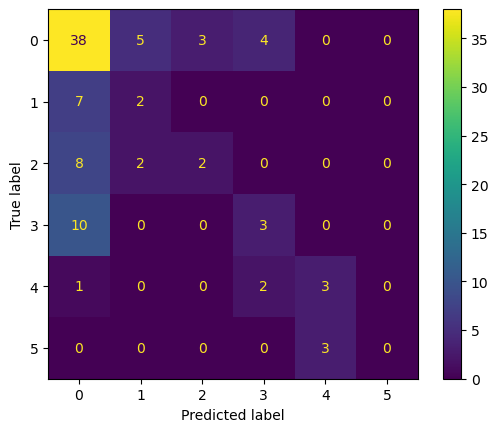

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labelist, predlist)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

# Run per epoches

In [30]:
def run_one_epoch(pretrain_mode = 'ConPro'):
    pretrain_mode = pretrain_mode

    data_dir = '/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity'
    image_datasets = {x: PapilledemaDataset(data_dir=data_dir, phase=x) for x in ['train', 'val', 'test']}

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
                for x in ['train', 'val', 'test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
    class_names = image_datasets['train'].classes

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # print(device, class_names)

    clf_model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
    if(pretrain_mode != 'ImageNet'):
        clf_model.load_state_dict(torch.load(f'./pretrained/pretrained-resnet50-{pretrain_mode}.pt'), strict=False)
    clf_model.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                    torch.nn.ReLU(),
                                    torch.nn.Dropout(0.1),
                                    torch.nn.Linear(1000, 256),
                                    torch.nn.ReLU(),
                                    torch.nn.Dropout(0.1),
                                    torch.nn.Linear(256, len(class_names)))

    class_weights= [0.31,       1.72222222, 1.29166667, 1.19230769, 2.58333333, 5.16666667]
    # print(class_weights)
    clf_model = clf_model.to(device)
    momentum = 0.9
    lr = 0.01
    optimizer_ft = optim.SGD([{'params': clf_model.fc[:].parameters()}], lr=lr, momentum=momentum)
    class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5)

    for param in clf_model.parameters():
        param.requires_grad = False
    for param in clf_model.fc[:].parameters():
        param.requires_grad = True
    
    valaccmax = 0
    for e in range(50):
        training_acc = 0
        val_acc = 0
        training_loss_test = 0.0

        for inputs, labels in dataloaders['train']:
            clf_model.train()
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer_ft.zero_grad()

            outputs = clf_model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer_ft.step()
            training_loss_test += loss.item() * inputs.size(0)
            training_acc += torch.sum(preds == labels.data)

        for inputs, labels in dataloaders['val']:
            clf_model.eval()
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = clf_model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = loss_fn(outputs, labels)

            val_acc += torch.sum(preds == labels.data)

        if(e > 8 and val_acc >= valaccmax):
            valaccmax = val_acc
            torch.save(clf_model.state_dict(), f'./pretrained/best-mutilclass-siamese50-{pretrain_mode}.pt')

        scheduler.step()

    bestmodel = models.resnet50(weights='ResNet50_Weights.DEFAULT')#get_feature_extractor(feature_extractor='resnet50', cotrain=False)#, simclr='/mnt/c/Users/PCM/Documents/GitHub/pseudopapill/SimCLR/runs/Oct29_21-00-13_DESKTOP-404G4HS/checkpoint_95_29102023.pth.tar')
    bestmodel.fc = nn.Sequential(torch.nn.Linear(2048, 1000),
                                    torch.nn.ReLU(),
                                    torch.nn.Dropout(0.1),
                                    torch.nn.Linear(1000, 256),
                                    torch.nn.ReLU(),
                                    torch.nn.Dropout(0.1),
                                    torch.nn.Linear(256, len(class_names)))
    bestmodel.load_state_dict(torch.load(f'./pretrained/best-mutilclass-siamese50-{pretrain_mode}.pt'))
    bestmodel.to(device)

    test_acc = 0
    predlist = []
    labelist = []
    problist = []
    # test_embeddings = torch.zeros((0, 2048))
    sedis = 0
    # fextractor = torch.nn.Sequential(*(list(clf_model.children())[:-1]))

    for inputs, labels in dataloaders['test']:
        bestmodel.eval()
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = bestmodel(inputs)
            # emb = fextractor(inputs)
            _, preds = torch.max(outputs, 1)
            # loss = loss_fn(outputs, labels)
            sedis = sedis + torch.sum(torch.exp(torch.abs(labels - torch.max(outputs, 1)[1])))
        problist.append(outputs[:,1].detach().cpu().numpy())
        labelist.append(labels.detach().cpu().numpy()*1)
        predlist.append(preds.detach().cpu().numpy())
        # test_embeddings  = torch.cat((test_embeddings, emb.detach().cpu().flatten().unsqueeze(0)), axis=0)
        test_acc += torch.sum(preds == labels.data)

    labelist = np.concatenate(labelist).ravel()
    problist = np.concatenate(problist).ravel()
    predlist = np.concatenate(predlist).ravel()
    return sedis/dataset_sizes['test'], f1_score(labelist, predlist, average='weighted'), f1_score(labelist, predlist, average='macro')
    # print('MAEE', sedis/dataset_sizes['test'])
    # print('weight F1', f1_score(labelist, predlist, average='weighted'))
    # print('macro F1', f1_score(labelist, predlist, average='macro'))
    # print(classification_report(labelist, predlist, digits=3))

In [31]:
maeelist = []
wf1list = []
mf1list = []

for i in range(30):
    print('Run #',i)
    maee, wf1, mf1 = run_one_epoch('SupCon5')
    print('MAEE', maee)
    print('weight F1', wf1)
    print('macro F1', mf1)
    maeelist.append(maee)
    wf1list.append(wf1)
    mf1list.append(mf1)

Run # 0


In [20]:
np.mean(torch.stack(maeelist).cpu().numpy())

6.955012

In [21]:
torch.stack(maeelist).cpu().numpy()

array([7.9301543, 7.4657617, 5.646627 , 6.8433857, 6.9685774, 5.713974 ,
       6.8964286, 7.6229773, 6.103554 , 6.677058 , 6.3613834, 9.017594 ,
       8.468648 , 7.057261 , 6.4172873, 7.20034  , 7.173798 , 6.867067 ,
       7.908414 , 6.713133 , 7.919269 , 6.2424607, 6.862925 , 7.220572 ,
       6.458567 , 5.816807 , 5.9272604, 6.387925 , 7.3420672, 7.4190793],
      dtype=float32)

In [23]:
np.array(wf1list)

array([0.45167458, 0.45852762, 0.52263185, 0.47129677, 0.47913616,
       0.46798551, 0.44278422, 0.44287191, 0.46738576, 0.47117741,
       0.45351873, 0.43029854, 0.45762693, 0.47775121, 0.48162963,
       0.4750384 , 0.44859187, 0.45623733, 0.48501998, 0.48594605,
       0.44047564, 0.45517946, 0.50051345, 0.436278  , 0.47776474,
       0.46614189, 0.48867874, 0.49319403, 0.46397204, 0.40569602])